In [2]:
%%capture
# Install required packages
!pip install -U transformers faiss-gpu torch Pillay tqdm ipywidgets
!pip install -U git+https://github.com/360CVGroup/FG-CLIP.git


## Initializations

In [1]:
import torch
import faiss
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from transformers import AutoProcessor, AutoModel
import matplotlib.pyplot as plt

# Configuration
IMAGE_ROOT = Path("debbiedebrauwer/Spanje")
MODEL_NAME = "qihoo360/fg-clip-large"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
INDEX_CONFIG = {
    "nlist": 256,          # Number of IVF clusters
    "nprobe": 16,          # Number of clusters to search
    "metric": faiss.METRIC_INNER_PRODUCT
}

# Initialize FG-CLIP model
processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()

W0612 12:46:11.097000 21512 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Vector Embedder (turns images into vector embeddings)

In [2]:
def load_image_paths():
    """Load all images with location metadata"""
    locations = []
    image_paths = []
    
    for loc_dir in IMAGE_ROOT.iterdir():
        if loc_dir.is_dir():
            loc_id = loc_dir.name
            for img_path in loc_dir.glob("*.*"):
                if img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                    image_paths.append(img_path)
                    locations.append(loc_id)
    
    return image_paths, locations


def generate_embeddings(image_paths, batch_size=BATCH_SIZE):
    """Generate FG-CLIP embeddings with batch processing"""
    embeddings = []
    
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i+batch_size]
        images = [Image.open(p).convert("RGB") for p in batch_paths]
        
        with torch.no_grad():
            inputs = processor(images=images, return_tensors="pt", padding=True)
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            features = model.get_image_features(**inputs)
            features = torch.nn.functional.normalize(features, dim=-1)
            embeddings.append(features.cpu().numpy())
    
    return np.concatenate(embeddings)

# Load and process all images
image_paths, location_ids = load_image_paths()
embeddings = generate_embeddings(image_paths)


  0%|          | 0/30 [00:00<?, ?it/s]

## Store embedding in database (only run once when storing vector embedding)

In [ ]:
from qdrant_client import QdrantClient, models
import hashlib
import numpy as np

# RUN THIS ONLY TO STORE THE EMBEDDINGS IN THE DATABASE

# Your data
# embeddings: np.ndarray of shape (num_images, embedding_dim)
# image_paths: list of image file paths (same order as embeddings)
# location_ids: list of location IDs (same order as embeddings)

# Set the path where you want to store Qdrant data
QDRANT_PATH = "./qdrant_data"

# Initialize Qdrant client in local (on-disk) mode
client = QdrantClient(path=QDRANT_PATH)

# Collection parameters
COLLECTION_NAME = "film_locations"
VECTOR_SIZE = embeddings.shape[1]

# Create or recreate collection
client.recreate_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=models.VectorParams(
        size=VECTOR_SIZE,
        distance=models.Distance.COSINE,
        on_disk=True  # Ensures vectors are stored on disk
    )
)

# Prepare points for upsert
def create_qdrant_points(image_paths, location_ids, embeddings):
    points = []
    for path, loc_id, vector in zip(image_paths, location_ids, embeddings):
        # Use a hash of the image path as a unique ID
        point_id = hashlib.md5(str(path).encode()).hexdigest()
        points.append(
            models.PointStruct(
                id=point_id,
                vector=vector.tolist(),
                payload={
                    "image_path": str(path),
                    "location_id": loc_id
                }
            )
        )
    return points

# Batch upsert to avoid memory issues
BATCH_SIZE = 1000
num_points = len(embeddings)
for i in range(0, num_points, BATCH_SIZE):
    batch_points = create_qdrant_points(
        image_paths[i:i+BATCH_SIZE],
        location_ids[i:i+BATCH_SIZE],
        embeddings[i:i+BATCH_SIZE]
    )
    client.upsert(
        collection_name=COLLECTION_NAME,
        points=batch_points
    )

print(f"Stored {num_points} embeddings in Qdrant at '{QDRANT_PATH}'")


C:\Users\elmak\AppData\Local\Temp\ipykernel_3264\1041582124.py:21: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


Stored 954 embeddings in Qdrant at './qdrant_data'


## Similarity Search (run this for the similarity search below to work)

In [2]:
import matplotlib.pyplot as plt
from qdrant_client import QdrantClient, models
from PIL import Image

# Collection parameters
COLLECTION_NAME = "film_locations"

def text_search(query: str, top_k: int = 5):
    """Search using text query."""
    with torch.no_grad():
        text_inputs = processor(text=query, return_tensors="pt", padding=True)
        text_inputs = {k: v.to(DEVICE) for k, v in text_inputs.items()}
        text_features = model.get_text_features(**text_inputs)
        query_embedding = torch.nn.functional.normalize(text_features, dim=-1)
    
    results = client.search(
        collection_name=COLLECTION_NAME,
        query_vector=query_embedding[0].cpu().numpy().tolist(),
        limit=top_k
    )
    
    return [{
        "score": hit.score,
        "image_path": hit.payload["image_path"],
        "location": hit.payload["location_id"]
    } for hit in results]

def plot_search_results(results, query, query_type="Text"):
    n = len(results)
    fig, axs = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axs = [axs]
    for ax, res in zip(axs, results):
        img = Image.open(res["image_path"])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Loc: {res['location']}\nScore: {res['score']:.2f}")
    plt.show()

def image_search(image_path: str, top_k: int = 5):
    """Search using image query."""
    image = Image.open(image_path).convert("RGB")
    with torch.no_grad():
        image_inputs = processor(images=image, return_tensors="pt")
        image_inputs = {k: v.to(DEVICE) for k, v in image_inputs.items()}
        image_features = model.get_image_features(**image_inputs)
        query_embedding = torch.nn.functional.normalize(image_features, dim=-1)
    
    results = client.search(
        collection_name=COLLECTION_NAME,
        query_vector=query_embedding[0].cpu().numpy().tolist(),
        limit=top_k
    )
    
    return [{
        "score": hit.score,
        "image_path": hit.payload["image_path"],
        "location": hit.payload["location_id"]
    } for hit in results]    

# QDRANT path
QDRANT_PATH = "./qdrant_data"

# Initialize Qdrant client in local (on-disk) mode
client = QdrantClient(path=QDRANT_PATH)

## Similarity search query (run above for this to work)

C:\Users\elmak\AppData\Local\Temp\ipykernel_21512\4120999091.py:16: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = client.search(


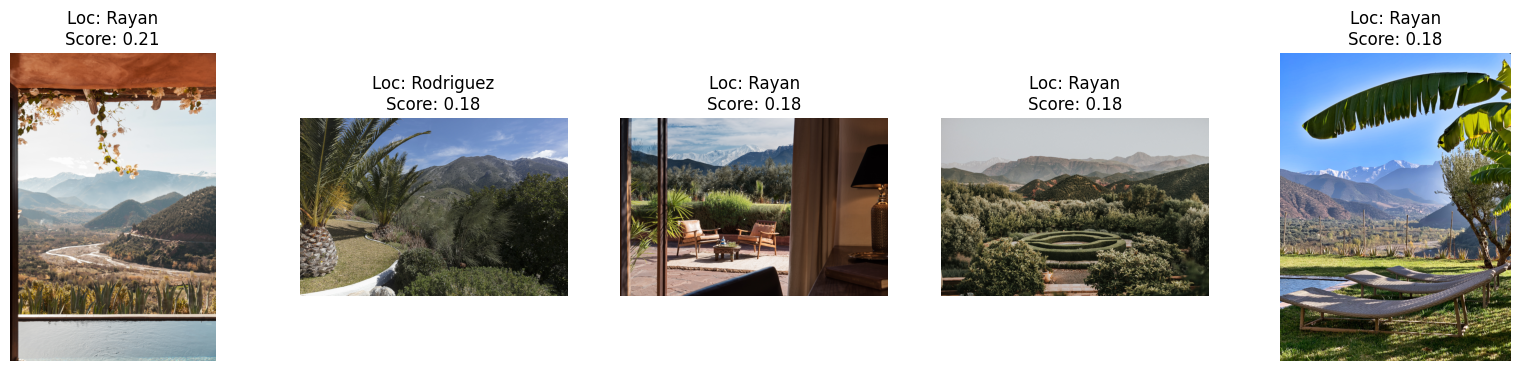

In [4]:
query = "outside nature look with mountains"
text_results = text_search(query, top_k=5)
plot_search_results(text_results, query, query_type="Text")

#image_results = image_search("path/to/your/query_image.jpg", top_k=5)
#for res in image_results:
#    print(f"{res['score']:.3f} | {res['location']}: {res['image_path']}")

In [3]:
''' import os
import pickle

def create_faiss_index(embeddings):
    """Create optimized FAISS index for FG-CLIP embeddings"""
    d = embeddings.shape[1]
    
    quantizer = faiss.IndexFlatIP(d)
    index = faiss.IndexIVFFlat(quantizer, d, INDEX_CONFIG["nlist"])
    
    # Train with 20% sample
    np.random.seed(42)
    sample_idx = np.random.choice(
        len(embeddings), 
        size=int(0.2*len(embeddings)), 
        replace=False
    )
    index.train(embeddings[sample_idx])
    
    index.add(embeddings)
    index.nprobe = INDEX_CONFIG["nprobe"]
    return index

index = create_faiss_index(embeddings)




# FAISS Index
def save_faiss_index(index, filename='faiss_index.index'):
    faiss.write_index(index, filename)
    print(f"FAISS index saved to {filename}")

# Metadata (image paths and location ids)
def save_metadata(image_paths, location_ids, filename='metadata.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump({'image_paths': image_paths, 'location_ids': location_ids}, f)
    print(f"Metadata saved to {filename}")

'''

# Embeddings save
def save_embeddings(embeddings, filename='fgclip_embeddings.npy'):
    np.save(filename, embeddings)
    print(f"Embeddings saved to {filename}")

In [4]:

save_embeddings(embeddings, 'fgclip_embeddings.npy')
'''
save_faiss_index(index, 'faiss_index.index')
save_metadata(image_paths, location_ids, 'metadata.pkl')
'''

Embeddings saved to fgclip_embeddings.npy


"\nsave_faiss_index(index, 'faiss_index.index')\nsave_metadata(image_paths, location_ids, 'metadata.pkl')\n"

In [2]:
class LocationRetrievalSystem:
    def __init__(self, index, image_paths, location_ids):
        self.index = index
        self.image_paths = image_paths
        self.locations = location_ids
        self.loc_db = {path: loc for path, loc in zip(image_paths, location_ids)}
        
    def _search(self, query_emb, k=10):
        """Core search functionality"""
        distances, indices = self.index.search(query_emb, k)
        return [
            (self.image_paths[i], distances[0][j], self.loc_db[self.image_paths[i]])
            for j, i in enumerate(indices[0])
        ]
    
    def query_image(self, image_path, k=10):
        """Search by image query"""
        query_emb = generate_embeddings([image_path])
        return self._search(query_emb, k)
    
    def query_text(self, text, k=10):
        """Search by text query"""
        with torch.no_grad():
            inputs = processor(text=text, return_tensors="pt", padding=True)
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            features = model.get_text_features(**inputs)
            features = torch.nn.functional.normalize(features, dim=-1)
            query_emb = features.cpu().numpy()
        
        return self._search(query_emb, k)
    
    def show_results(self, results):
        """Visualize top results with location metadata"""
        plt.figure(figsize=(20, 10))
        for i, (path, score, loc) in enumerate(results[:5]):
            plt.subplot(1, 5, i+1)
            plt.imshow(Image.open(path))
            plt.title(f"Location: {loc}\nScore: {score:.3f}")
            plt.axis('off')
        plt.show()



In [16]:
def location_aggregation(results):
    """Group results by location and calculate aggregate scores"""
    from collections import defaultdict
    loc_scores = defaultdict(list)
    
    for path, score, loc in results:
        loc_scores[loc].append(score)
    
    # Calculate weighted average (exponential decay)
    return sorted([
        (loc, np.mean(scores) * np.log1p(len(scores)))
        for loc, scores in loc_scores.items()
    ], key=lambda x: -x[1])

def rerank_by_color(query_image, results):
    """Secondary ranking using color histograms"""
    # Implement CIEDE2000 color difference calculation
    # (Requires additional color processing logic)
    pass


In [3]:
import os
import pickle

def load_embeddings(filename='fgclip_embeddings.npy'):
    if os.path.exists(filename):
        embeddings = np.load(filename)
        print(f"Embeddings loaded from {filename}, shape: {embeddings.shape}")
        return embeddings
    else:
        print(f"File {filename} not found.")
        return None
    
def load_faiss_index(filename='faiss_index.index'):
    if os.path.exists(filename):
        index = faiss.read_index(filename)
        print(f"FAISS index loaded from {filename}")
        return index
    else:
        print(f"File {filename} not found.")
        return None
    
def load_metadata(filename='metadata.pkl'):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        print(f"Metadata loaded from {filename}")
        return data['image_paths'], data['location_ids']
    else:
        print(f"File {filename} not found.")
        return None, None

In [4]:
# load saved data
embeddings = load_embeddings('fgclip_embeddings.npy')
'''
index = load_faiss_index('faiss_index.index')
image_paths, location_ids = load_metadata('metadata.pkl')

# Initiate retrieval system
retrieval_system = LocationRetrievalSystem(index, image_paths, location_ids)
'''

Embeddings loaded from fgclip_embeddings.npy, shape: (823, 768)


"\nindex = load_faiss_index('faiss_index.index')\nimage_paths, location_ids = load_metadata('metadata.pkl')\n\n# Initiate retrieval system\nretrieval_system = LocationRetrievalSystem(index, image_paths, location_ids)\n"

Searching for driveway for a car


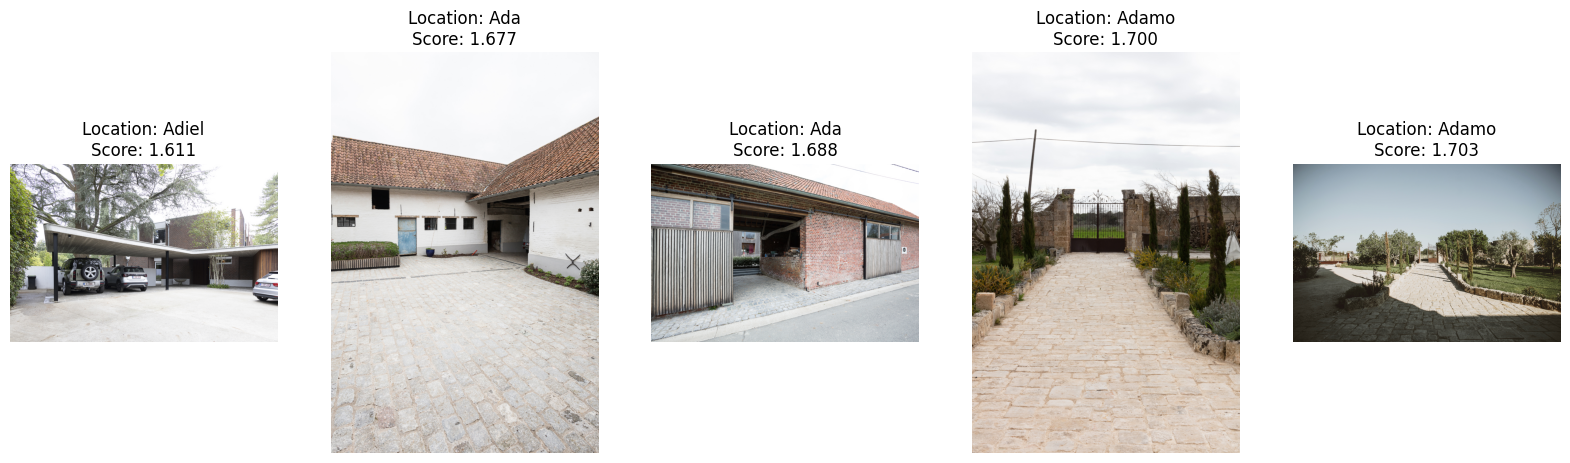

Top Locations:
Aldo: 1.897
Adamo: 1.869
Ada: 1.848
Searching similar to images\Aaron\AARON_StudioScott_-0658_LR.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

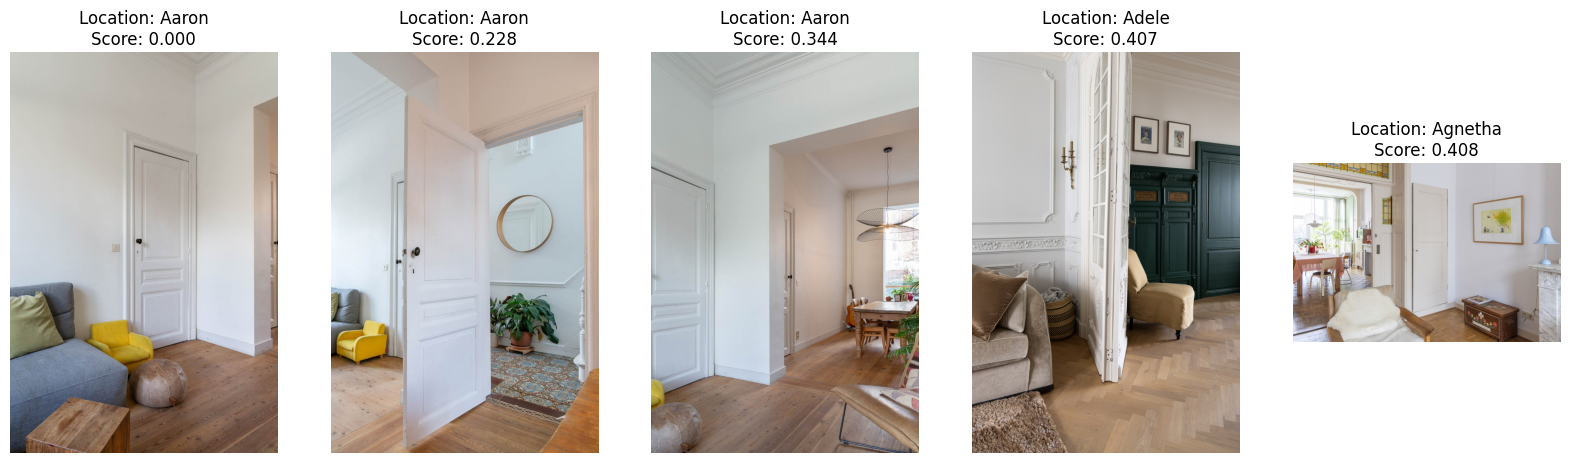

In [20]:
# Text Query Example
query = "driveway for a car" # try driveway for a car, yellow chair
print(f"Searching for {query}")
results = retrieval_system.query_text(query)
retrieval_system.show_results(results)

# Location-based Aggregation
aggregated = location_aggregation(results)
print("Top Locations:")
for loc, score in aggregated[:3]:
    print(f"{loc}: {score:.3f}")

# Image Query Example
sample_image = "images\Aaron\AARON_StudioScott_-0658_LR.jpg"
print(f"Searching similar to {sample_image}")
results = retrieval_system.query_image(sample_image)
retrieval_system.show_results(results)